<a href="https://colab.research.google.com/github/nefter/EDA/blob/master/reto_fraude_notebook_pulido_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reto de Fraude en Carritos — Notebook de entrega (ML 1)

Este notebook está diseñado para que se vea **profesional y “defendible”** en un primer curso de Modelos de ML.

## Objetivos
**Reto I (Clasificación):** predecir `fraud_flag` (fraude vs no fraude) a partir de la composición del carrito y variables agregadas (costo, #items, etc.).

**Reto II (Regresión / cuantificación):** si existe un monto real de fraude lo usamos; si no, definimos un **proxy razonable** (por ejemplo `costo_total`) y justificamos la elección.

## Qué vas a entregar aquí
- Balance de clases de `fraud_flag` y por qué importa.
- Baseline (modelo tonto) + al menos 1 modelo interpretable (LogReg Ridge).
- Comparación breve con 1 modelo no lineal (RandomForest) **para justificar decisiones**, no para “adivinar”.
- Métricas correctas para fraude: **precision, recall, F1, PR-AUC** (+ ROC-AUC opcional).
- (Opcional recomendado) Ajuste de umbral para controlar falsos negativos.

> Nota: este dataset **no tiene texto**. Las columnas tipo `CATEGORIA | MARCA | PRODUCTO ...` ya son features numéricas (conteos/cantidades).  
> Por eso **NO se usa TF-IDF/BOW de NLP**.


In [1]:
# (Opcional) Montar Google Drive si estás en Colab
try:
    from google.colab import drive
    drive.mount('/content/drive')
    IN_COLAB = True
except Exception:
    IN_COLAB = False
    print("No estoy en Colab (o no monté Drive). Continuo...")

Mounted at /content/drive


In [2]:
# === Setup ===
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MaxAbsScaler
from sklearn.impute import SimpleImputer

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, average_precision_score,
    precision_recall_curve, roc_curve,
    mean_absolute_error, mean_squared_error, r2_score
)

import warnings
warnings.filterwarnings("ignore")

# Ajusta la ruta del CSV
CSV_PATH = r"/content/drive/MyDrive/Bourbaki/FraudeCanastas.csv"  # <-- cambia si es necesario

from scipy.sparse import csr_matrix


## 1) Carga y revisión rápida de datos

Asegúrate de:
- identificar `fraud_flag`
- eliminar identificadores que no aporten (por ejemplo `ID`)
- revisar nulos y tipos


In [3]:
# === Cargar datos ===
df = pd.read_csv(CSV_PATH, low_memory=False)

print("Shape:", df.shape)
display(df.head(3))

# Info rápida: target + algunas columnas numéricas
display(df.describe(include="all").T.head(20))


Shape: (9319, 2457)


,ID,APPLE PRODUCTDESCRIPTION | SAMSUNG | MODEL90,AUDIO ACCESSORIES | AB AUDIO | AB AUDIO GO AIR TRUE WIRELESS BLUETOOTH IN-EAR H,AUDIO ACCESSORIES | APPLE | 2019 APPLE AIRPODS WITH CHARGING CASE,AUDIO ACCESSORIES | APPLE | 2019 APPLE AIRPODS WITH CHARGING CASE 2ND GENERATI,AUDIO ACCESSORIES | APPLE | 2019 APPLE AIRPODS WITH WIRELESS CHARGING CASE,AUDIO ACCESSORIES | APPLE | 2019 APPLE AIRPODS WITH WIRELESS CHARGING CASE 2ND,AUDIO ACCESSORIES | APPLE | 2021 APPLE AIRPODS WITH MAGSAFE CHARGING CASE 3RD,AUDIO ACCESSORIES | APPLE | AIRPODS PRO,AUDIO ACCESSORIES | APPLE | APPLE AIRPODS MAX,...,WOMEN S NIGHTWEAR | ANYDAY RETAILER | ANYDAY RETAILER LEOPARD PRINT JERSEY PY,WOMEN S NIGHTWEAR | RETAILER | RETAILER CLEO VELOUR JOGGER LOUNGE PANT,WOMEN S NIGHTWEAR | SOSANDAR | SOSANDAR ZEBRA PRINT PYJAMA BOTTOMS BLACK 10,Nb_of_items,total_of_items,costo_total,costo_medio_item,costo_item_max,costo_item_min,fraud_flag
0,130,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2,2,1299,649.5,1299,0.0,1.0
1,195,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3,3,4119,1373.0,2470,0.0,1.0
2,217,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2,2,2806,1403.0,2799,7.0,1.0


,count,mean,std,min,25%,50%,75%,max
ID,9319.0,58763.568409,33714.628042,45.0,29529.0,58489.0,88902.5,115942.0
APPLE PRODUCTDESCRIPTION | SAMSUNG | MODEL90,9319.0,0.107308,10.358941,0.0,0.0,0.0,0.0,1000.0
AUDIO ACCESSORIES | AB AUDIO | AB AUDIO GO AIR TRUE WIRELESS BLUETOOTH IN-EAR H,9319.0,0.002146,0.207179,0.0,0.0,0.0,0.0,20.0
AUDIO ACCESSORIES | APPLE | 2019 APPLE AIRPODS WITH CHARGING CASE,9319.0,0.305290,7.606907,0.0,0.0,0.0,0.0,500.0
AUDIO ACCESSORIES | APPLE | 2019 APPLE AIRPODS WITH CHARGING CASE 2ND GENERATI,9319.0,0.207533,6.133545,0.0,0.0,0.0,0.0,436.0
AUDIO ACCESSORIES | APPLE | 2019 APPLE AIRPODS WITH WIRELESS CHARGING CASE,9319.0,0.050971,2.843956,0.0,0.0,0.0,0.0,168.0
AUDIO ACCESSORIES | APPLE | 2019 APPLE AIRPODS WITH WIRELESS CHARGING CASE 2ND,9319.0,0.014916,1.439893,0.0,0.0,0.0,0.0,139.0
AUDIO ACCESSORIES | APPLE | 2021 APPLE AIRPODS WITH MAGSAFE CHARGING CASE 3RD,9319.0,0.292521,6.848110,0.0,0.0,0.0,0.0,169.0
AUDIO ACCESSORIES | APPLE | AIRPODS PRO,9319.0,0.230175,6.695964,0.0,0.0,0.0,0.0,195.0
AUDIO ACCESSORIES | APPLE | APPLE AIRPODS MAX,9319.0,0.353471,13.926653,0.0,0.0,0.0,0.0,549.0


In [4]:
# === Definir target y features ===
TARGET_CLASS = "fraud_flag"
if TARGET_CLASS not in df.columns:
    raise ValueError(f"No encontré '{TARGET_CLASS}'. Columnas: {list(df.columns)[:30]} ...")

# y (clasificación)
y = df[TARGET_CLASS].astype(int)

# X
X = df.drop(columns=[TARGET_CLASS])

# Quitar identificadores si existen (evita memorizar)
for col in ["ID", "id", "Id"]:
    if col in X.columns:
        X = X.drop(columns=[col])


# Convertir a numérico y rellenar NaNs (dataset es altamente esparso)
X = X.apply(pd.to_numeric, errors="coerce").fillna(0).astype(np.float32)

# Convertir a matriz sparse CSR para ahorrar memoria y acelerar (muchos ceros)
X_sparse = csr_matrix(X.values)

print("Balance de clases (conteo):")
display(y.value_counts())

print("Balance de clases (%):")
display((y.value_counts(normalize=True)*100).round(2))

print("\nNulos totales en X:", int(X.isna().sum().sum()))


Balance de clases (conteo):


,count
fraud_flag,
0,8000
1,1319


Balance de clases (%):


,proportion
fraud_flag,
0,85.85
1,14.15



Nulos totales en X: 0


In [6]:
# === Preprocesamiento (dataset numérico y altamente esparso) ===
# Como casi todo son conteos/cantidades (muchos ceros), conviene trabajar en formato sparse y escalar con MaxAbsScaler
# (no centra en 0, por lo que mantiene la sparsidad).
preprocess = Pipeline(steps=[
    ("scaler", MaxAbsScaler())
])


In [7]:
# === Helpers de evaluación ===
def _get_scores(model, X_):
    """Devuelve scores continuos para PR/ROC.
    Preferimos predict_proba; si no existe, intentamos decision_function.
    """
    if hasattr(model, "predict_proba"):
        return model.predict_proba(X_)[:, 1]
    if hasattr(model, "decision_function"):
        s = model.decision_function(X_)
        # normaliza a [0,1] solo para graficar; para PR-AUC sirve como score continuo
        s_min, s_max = np.min(s), np.max(s)
        if s_max > s_min:
            return (s - s_min) / (s_max - s_min)
        return s
    return None

def evaluate_classifier(name, model, X_test, y_test, threshold=0.5, show_plots=True):
    scores = _get_scores(model, X_test)
    if scores is None:
        y_pred = model.predict(X_test)
    else:
        y_pred = (scores >= threshold).astype(int)

    print(f"\n=== {name} (threshold={threshold:.2f}) ===")
    print(classification_report(y_test, y_pred, digits=4))
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion matrix [ [TN FP] [FN TP] ]:\n", cm)

    out = {"model": name}
    # métricas con scores
    if scores is not None and y_test.nunique() == 2:
        out["roc_auc"] = roc_auc_score(y_test, scores)
        out["pr_auc"] = average_precision_score(y_test, scores)
        print(f"ROC-AUC: {out['roc_auc']:.4f}")
        print(f"PR-AUC:  {out['pr_auc']:.4f}")

        if show_plots:
            # PR curve
            p, r, t = precision_recall_curve(y_test, scores)
            plt.figure()
            plt.plot(r, p)
            plt.xlabel("Recall")
            plt.ylabel("Precision")
            plt.title(f"Precision-Recall curve — {name}")
            plt.show()

            # ROC curve
            fpr, tpr, _ = roc_curve(y_test, scores)
            plt.figure()
            plt.plot(fpr, tpr)
            plt.xlabel("FPR")
            plt.ylabel("TPR")
            plt.title(f"ROC curve — {name}")
            plt.show()

    return out, scores


## 2) Reto I — Clasificación (fraud_flag)

Estrategia mínima sólida:
1) Split estratificado
2) Baseline: `most_frequent`
3) LogReg con L2 (Ridge) + `class_weight='balanced'`
4) Comparación opcional: RandomForest
5) Evaluación con PR-AUC + reporte de clasificación y matriz de confusión


In [8]:
# === Split estratificado ===
can_stratify = (y.nunique() == 2) and (y.value_counts().min() >= 2)

X_train, X_test, y_train, y_test = train_test_split(
    X_sparse, y,
    test_size=0.25,
    random_state=42,
    stratify=y if can_stratify else None
)

print("Train:", X_train.shape, " Test:", X_test.shape, "(sparse)")


Train: (6989, 2455)  Test: (2330, 2455) (sparse)


In [9]:
# === Baseline: clase mayoritaria ===
baseline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", DummyClassifier(strategy="most_frequent"))
])

baseline.fit(X_train, y_train)
_ = evaluate_classifier("Baseline (most_frequent)", baseline, X_test, y_test, threshold=0.5, show_plots=False)



=== Baseline (most_frequent) (threshold=0.50) ===
              precision    recall  f1-score   support

           0     0.8584    1.0000    0.9238      2000
           1     0.0000    0.0000    0.0000       330

    accuracy                         0.8584      2330
   macro avg     0.4292    0.5000    0.4619      2330
weighted avg     0.7368    0.8584    0.7930      2330

Confusion matrix [ [TN FP] [FN TP] ]:
 [[2000    0]
 [ 330    0]]
ROC-AUC: 0.5000
PR-AUC:  0.1416



=== LogReg (L2, balanced) (threshold=0.50) ===
              precision    recall  f1-score   support

           0     0.9392    0.7640    0.8426      2000
           1     0.3286    0.7000    0.4472       330

    accuracy                         0.7549      2330
   macro avg     0.6339    0.7320    0.6449      2330
weighted avg     0.8527    0.7549    0.7866      2330

Confusion matrix [ [TN FP] [FN TP] ]:
 [[1528  472]
 [  99  231]]
ROC-AUC: 0.8183
PR-AUC:  0.4068


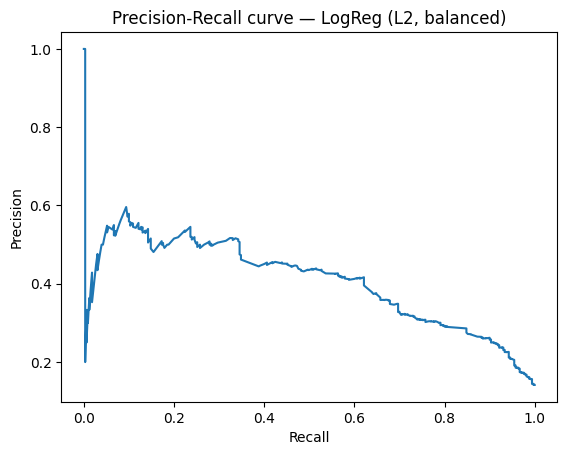

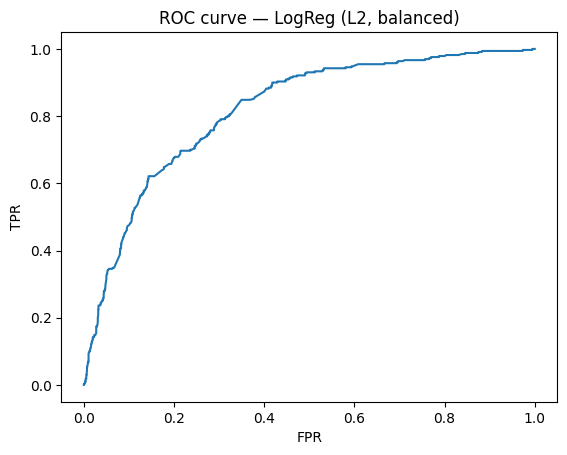

In [10]:
# === Modelo 1: Logistic Regression + L2 (Ridge) ===
logreg = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LogisticRegression(
        penalty="l2",
        solver="saga",          # funciona con muchos features y sparse
        max_iter=5000,
        class_weight="balanced" # clave si hay desbalance
    ))
])

logreg.fit(X_train, y_train)
logreg_metrics, logreg_scores = evaluate_classifier("LogReg (L2, balanced)", logreg, X_test, y_test)


Mejor C: {'model__C': 10}
Mejor PR-AUC (CV): 0.4827

=== LogReg tuned (best C) (threshold=0.50) ===
              precision    recall  f1-score   support

           0     0.9429    0.7520    0.8367      2000
           1     0.3252    0.7242    0.4488       330

    accuracy                         0.7481      2330
   macro avg     0.6341    0.7381    0.6428      2330
weighted avg     0.8555    0.7481    0.7818      2330

Confusion matrix [ [TN FP] [FN TP] ]:
 [[1504  496]
 [  91  239]]
ROC-AUC: 0.8240
PR-AUC:  0.4296


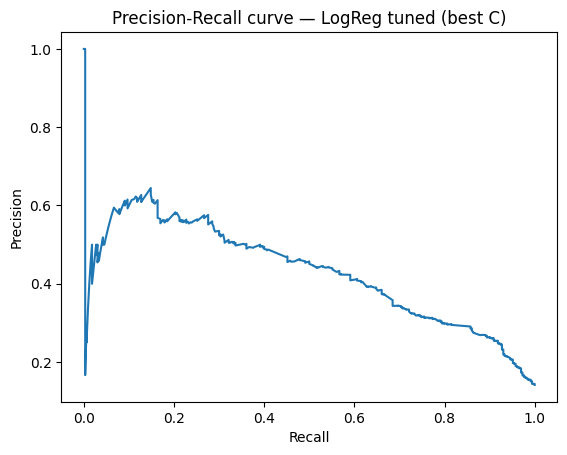

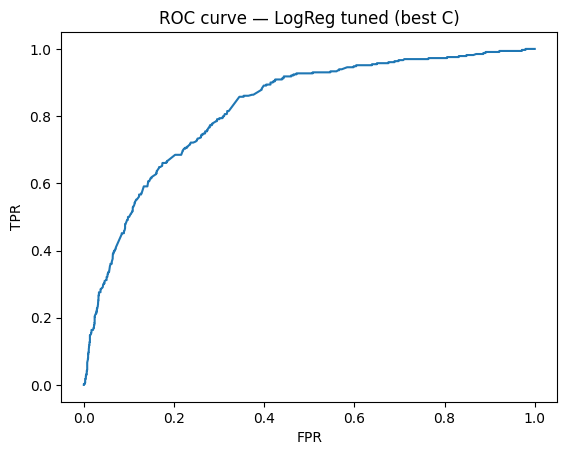

In [11]:
# === Tuning simple de regularización (C = 1/lambda) con CV ===
# Esto es lo típico “de curso 1”: barrido pequeño y explicación clara.

param_grid = {
    "model__C": [0.01, 0.1, 1, 10, 100],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

gs = GridSearchCV(
    estimator=logreg,
    param_grid=param_grid,
    scoring="average_precision",  # PR-AUC: mejor para fraude/desbalance
    cv=cv,
    n_jobs=-1
)
gs.fit(X_train, y_train)

print("Mejor C:", gs.best_params_)
print("Mejor PR-AUC (CV):", round(gs.best_score_, 4))

best_logreg = gs.best_estimator_
best_metrics, best_scores = evaluate_classifier("LogReg tuned (best C)", best_logreg, X_test, y_test)


,param_model__C,mean_test_score,std_test_score,C
0,0.01,0.376244,0.035571,0.01
1,0.10,0.420874,0.030694,0.10
2,1.00,0.469582,0.042003,1.00
3,10.00,0.482679,0.042776,10.00
4,100.00,0.471969,0.038473,100.00


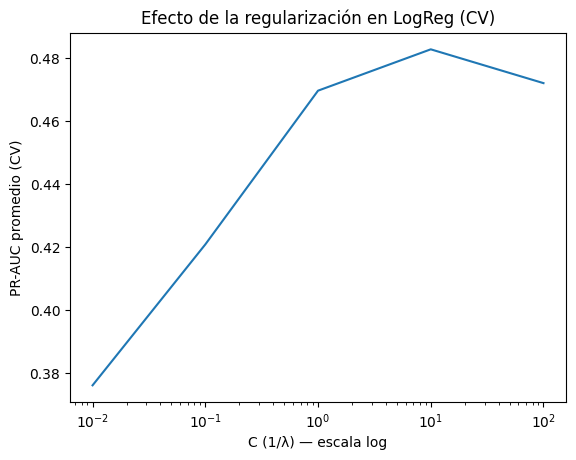

In [12]:
# === Visualización: desempeño vs C (regularización) ===
cvres = pd.DataFrame(gs.cv_results_)
# Extraemos C y score
plot_df = cvres[["param_model__C","mean_test_score","std_test_score"]].copy()
plot_df["C"] = plot_df["param_model__C"].astype(float)
plot_df = plot_df.sort_values("C")
display(plot_df)

plt.figure()
plt.plot(plot_df["C"], plot_df["mean_test_score"])
plt.xscale("log")
plt.xlabel("C (1/λ) — escala log")
plt.ylabel("PR-AUC promedio (CV)")
plt.title("Efecto de la regularización en LogReg (CV)")
plt.show()


In [13]:
# === Interpretabilidad (LogReg): features más asociadas a fraude/no-fraude ===
# Nota: interpretamos coeficientes en el espacio transformado (después de preprocess).
pre = best_logreg.named_steps["preprocess"]
mdl = best_logreg.named_steps["model"]

if hasattr(pre, "get_feature_names_out"):
    feat_names = pre.get_feature_names_out()
    coefs = mdl.coef_.ravel()
    coef_df = pd.DataFrame({"feature": feat_names, "coef": coefs})
    coef_df["abs"] = coef_df["coef"].abs()
    top_pos = coef_df.sort_values("coef", ascending=False).head(20)[["feature","coef"]]
    top_neg = coef_df.sort_values("coef", ascending=True).head(20)[["feature","coef"]]

    print("Top + (aumentan prob. de fraude):")
    display(top_pos)

    print("Top - (disminuyen prob. de fraude):")
    display(top_neg)
else:
    print("Tu versión de sklearn no soporta get_feature_names_out() aquí.")


Top + (aumentan prob. de fraude):


,feature,coef
911,x911,12.660182
893,x893,12.274076
916,x916,11.353717
1104,x1104,8.754098
901,x901,8.119952
908,x908,7.427997
918,x918,7.408361
894,x894,6.852067
2232,x2232,6.573685
887,x887,6.339930


Top - (disminuyen prob. de fraude):


,feature,coef
2402,x2402,-8.088485
672,x672,-6.766382
733,x733,-5.773439
2288,x2288,-5.283454
797,x797,-5.244696
2257,x2257,-5.224287
2381,x2381,-5.030727
2017,x2017,-4.922860
1423,x1423,-4.709751
748,x748,-4.486254



=== RandomForest (threshold=0.50) ===
              precision    recall  f1-score   support

           0     0.9410    0.7335    0.8244      2000
           1     0.3087    0.7212    0.4323       330

    accuracy                         0.7318      2330
   macro avg     0.6248    0.7274    0.6284      2330
weighted avg     0.8514    0.7318    0.7689      2330

Confusion matrix [ [TN FP] [FN TP] ]:
 [[1467  533]
 [  92  238]]
ROC-AUC: 0.8068
PR-AUC:  0.4612


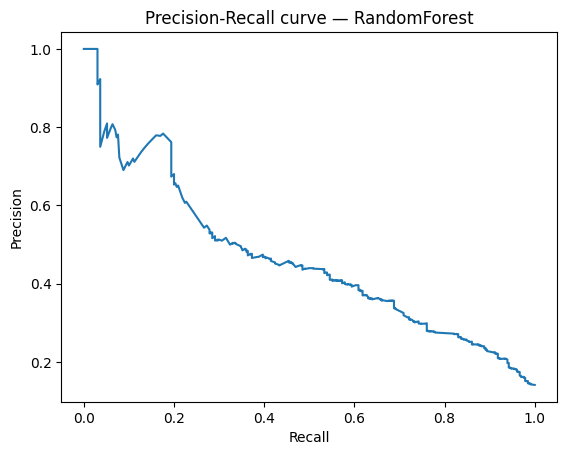

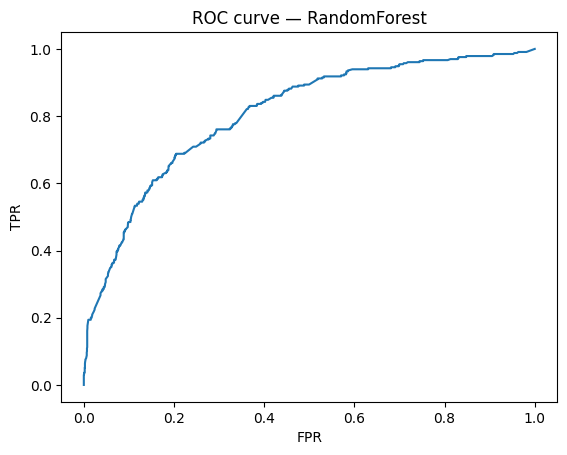

In [14]:
# === Modelo 2 (comparación): RandomForestClassifier ===
# Justificación: puede capturar no linealidades e interacciones, pero es menos interpretable y puede sobreajustar.
rf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", RandomForestClassifier(
        n_estimators=400,
        random_state=42,
        n_jobs=-1,
        class_weight="balanced_subsample",
        min_samples_leaf=2
    ))
])

rf.fit(X_train, y_train)
rf_metrics, rf_scores = evaluate_classifier("RandomForest", rf, X_test, y_test)


In [15]:
# === Comparación rápida en una tabla ===
rows = []
for m in [logreg_metrics, best_metrics, rf_metrics]:
    rows.append({
        "Modelo": m.get("model"),
        "ROC-AUC": m.get("roc_auc", np.nan),
        "PR-AUC": m.get("pr_auc", np.nan),
    })
cmp = pd.DataFrame(rows)
display(cmp)


,Modelo,ROC-AUC,PR-AUC
0,"LogReg (L2, balanced)",0.818283,0.406842
1,LogReg tuned (best C),0.823989,0.429555
2,RandomForest,0.806768,0.461194


### (Opcional recomendado) Ajuste de umbral

En fraude casi nunca quieres quedarte con umbral 0.5 sin pensar:
- bajar el umbral suele **aumentar recall** (menos falsos negativos), pero baja precision.
- sube el umbral si te importa evitar falsos positivos.


In [16]:
# === Ajuste simple de umbral (sobre el mejor LogReg) ===
# Elegimos el umbral que maximiza F1, o que cumpla un recall mínimo.
from sklearn.metrics import f1_score, precision_score, recall_score

scores = best_scores if best_scores is not None else _get_scores(best_logreg, X_test)
if scores is None:
    print("Este modelo no tiene scores continuos; no puedo ajustar umbral.")
else:
    thresholds = np.linspace(0.05, 0.95, 19)
    grid = []
    for th in thresholds:
        pred = (scores >= th).astype(int)
        grid.append({
            "threshold": th,
            "precision": precision_score(y_test, pred, zero_division=0),
            "recall": recall_score(y_test, pred, zero_division=0),
            "f1": f1_score(y_test, pred, zero_division=0),
        })
    grid = pd.DataFrame(grid).sort_values("f1", ascending=False)
    display(grid.head(10))

    best_th = float(grid.iloc[0]["threshold"])
    print("Umbral que maximiza F1:", best_th)
    _ = evaluate_classifier("Best LogReg @ tuned threshold", best_logreg, X_test, y_test, threshold=best_th, show_plots=False)


,threshold,precision,recall,f1
12,0.65,0.422993,0.590909,0.493047
11,0.60,0.382562,0.651515,0.482063
13,0.70,0.446809,0.509091,0.475921
10,0.55,0.341176,0.703030,0.459406
9,0.50,0.325170,0.724242,0.448826
8,0.45,0.313676,0.757576,0.443656
7,0.40,0.300804,0.793939,0.436303
14,0.75,0.498054,0.387879,0.436116
6,0.35,0.267760,0.890909,0.411765
5,0.30,0.263298,0.900000,0.407407


Umbral que maximiza F1: 0.65

=== Best LogReg @ tuned threshold (threshold=0.65) ===
              precision    recall  f1-score   support

           0     0.9278    0.8670    0.8964      2000
           1     0.4230    0.5909    0.4930       330

    accuracy                         0.8279      2330
   macro avg     0.6754    0.7290    0.6947      2330
weighted avg     0.8563    0.8279    0.8392      2330

Confusion matrix [ [TN FP] [FN TP] ]:
 [[1734  266]
 [ 135  195]]
ROC-AUC: 0.8240
PR-AUC:  0.4296


## 3) Reto II — Regresión (cuantificar impacto)

Si el dataset trae una columna de monto real (p.ej. `fraud_amount`), úsala.

Si no existe, definimos un proxy **justificable**:
- `costo_total` es un buen candidato si representa el valor del carrito.
- También podemos cuantificar “costo esperado” como `fraud_flag * costo_total` (solo hay impacto cuando hay fraude).

Reportamos: MAE, RMSE, R².


In [17]:
# === Reto II: definir y_reg (monto real o proxy) ===
# Buscamos una columna “monto real” típica; si no existe, usamos proxy.
amount_aliases = {"fraud_amount", "fraud_value", "monto_fraude", "valor_fraude", "monto", "amount"}
possible_amount_cols = [c for c in df.columns if c.lower() in amount_aliases]
print("Posibles columnas de monto real:", possible_amount_cols)

if possible_amount_cols:
    TARGET_REG = possible_amount_cols[0]
    y_reg = df[TARGET_REG].astype(float)
    X_reg = df.drop(columns=[TARGET_REG, TARGET_CLASS], errors="ignore")
    for col in ["ID", "id", "Id"]:
        if col in X_reg.columns:
            X_reg = X_reg.drop(columns=[col])
    print(f"Usando '{TARGET_REG}' como y_reg (monto real).")
else:
    # Proxy recomendado para carritos: costo_total si existe
    if "costo_total" in df.columns:
        TARGET_REG = "costo_total"
        y_reg = df[TARGET_REG].astype(float)
        print("No hay monto real. Usaré proxy y_reg = costo_total (valor del carrito).")
    else:
        # fallback: suma de items agregados si existe, si no suma de todas las columnas numéricas no agregadas
        if "total_of_items" in df.columns:
            TARGET_REG = "total_of_items"
            y_reg = df[TARGET_REG].astype(float)
            print("No hay costo_total. Usaré proxy y_reg = total_of_items.")
        else:
            # último recurso: suma de columnas numéricas (puede ser ruidoso)
            num_cols_all = df.select_dtypes(include=[np.number]).columns.tolist()
            num_cols_all = [c for c in num_cols_all if c != TARGET_CLASS]
            y_reg = df[num_cols_all].fillna(0).sum(axis=1).astype(float)
            TARGET_REG = "proxy_sum_numeric"
            print("Usé y_reg como suma de columnas numéricas (proxy débil).")

    # Features para regresión: todo menos fraud_flag y el target proxy elegido
    X_reg = df.drop(columns=[TARGET_CLASS, TARGET_REG], errors="ignore")
    for col in ["ID", "id", "Id"]:
        if col in X_reg.columns:
            X_reg = X_reg.drop(columns=[col])

# Impacto solo cuando hay fraude (opcional)
y_reg_fraud_only = (df[TARGET_CLASS].astype(int) * y_reg).astype(float)

print("Resumen y_reg:")
display(pd.Series(y_reg).describe())
print("\nResumen y_reg_fraud_only (fraud_flag * y_reg):")
display(pd.Series(y_reg_fraud_only).describe())

# Elegimos por defecto modelar y_reg_fraud_only (impacto esperado observable)
Y_REG_TO_MODEL = y_reg_fraud_only


Posibles columnas de monto real: []
No hay monto real. Usaré proxy y_reg = costo_total (valor del carrito).
Resumen y_reg:


,costo_total
count,9319.000000
mean,1337.801052
std,1070.597321
min,219.000000
25%,838.000000
50%,1124.000000
75%,1612.000000
max,24551.000000



Resumen y_reg_fraud_only (fraud_flag * y_reg):


,0
count,9319.000000
mean,228.584397
std,732.788031
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,24551.000000


In [18]:
# === Entrenar regresión (Ridge vs RandomForestRegressor) ===
from sklearn.model_selection import KFold

# split
Xr_train, Xr_test, yr_train, yr_test = train_test_split(
    X_reg, Y_REG_TO_MODEL, test_size=0.25, random_state=42
)

# preprocess para regresión
num_cols_r = X_reg.select_dtypes(include=[np.number]).columns.tolist()
cat_cols_r = [c for c in X_reg.columns if c not in num_cols_r]

transformers_r = []
if num_cols_r:
    transformers_r.append(("num", Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler(with_mean=False))
    ]), num_cols_r))
if cat_cols_r:
    transformers_r.append(("cat", Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ]), cat_cols_r))

preprocess_r = ColumnTransformer(transformers=transformers_r, remainder="drop")

# Ridge regression (alpha = lambda)
ridge = Pipeline(steps=[
    ("preprocess", preprocess_r),
    ("model", Ridge(alpha=1.0, random_state=42))
])

ridge.fit(Xr_train, yr_train)
pred = ridge.predict(Xr_test)

mae = mean_absolute_error(yr_test, pred)
rmse = np.sqrt(mean_squared_error(yr_test, pred))
r2 = r2_score(yr_test, pred)

print("=== Ridge Regression ===")
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²:   {r2:.4f}")

# RandomForestRegressor
rfr = Pipeline(steps=[
    ("preprocess", preprocess_r),
    ("model", RandomForestRegressor(
        n_estimators=300, random_state=42, n_jobs=-1,
        min_samples_leaf=2
    ))
])

rfr.fit(Xr_train, yr_train)
pred2 = rfr.predict(Xr_test)

mae2 = mean_absolute_error(yr_test, pred2)
rmse2 = np.sqrt(mean_squared_error(yr_test, pred2))
r22 = r2_score(yr_test, pred2)

print("\n=== RandomForestRegressor ===")
print(f"MAE:  {mae2:.4f}")
print(f"RMSE: {rmse2:.4f}")
print(f"R²:   {r22:.4f}")


=== Ridge Regression ===
MAE:  439.0102
RMSE: 919.0404
R²:   -0.6934

=== RandomForestRegressor ===
MAE:  248.6869
RMSE: 556.3624
R²:   0.3794
